In [28]:
import cv2
from roboflow import Roboflow
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tempfile
import os

In [29]:
# Roboflow Foot Segmentation Model
rf = Roboflow(api_key="XQT1SoOf1JBOKrLJDzSO")
project = rf.workspace().project("trackstar")
model = project.version(4).model
print("Model loaded.")

loading Roboflow workspace...
loading Roboflow project...
Model loaded.


In [83]:
def check_infraction(model, confidence, image, plot=True):
    infraction = False
    filename = None
    
    # Determine whether `image` is a file path (string) or a NumPy array (frame)
    if isinstance(image, str):
        filename = os.path.splitext(os.path.basename(image))[0]
        predictions = model.predict(image, confidence=confidence).json()['predictions']
        original_image = Image.open(image)  # Load directly if it's a file path
    else:
        # Convert OpenCV frame to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".jpg", delete=True) as temp:
            cv2.imwrite(temp.name, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            predictions = model.predict(temp.name, confidence=confidence).json()['predictions']

        # Convert NumPy array to PIL image
        original_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Create a copy for drawing
    image = original_image.copy()
    draw = ImageDraw.Draw(image)

    # Lists to store all polygons for "foot" and "track line"
    foot_polygons = []
    track_line_polygons = []

    # Loop through predictions to find polygons for "foot" and "track line"
    for prediction in predictions:
        if prediction["class"] == "foot":
            foot_polygon_points = [(point["x"], point["y"]) for point in prediction["points"]]
            foot_polygons.append(Polygon(foot_polygon_points))
        elif prediction["class"] == "track line":
            track_line_polygon_points = [(point["x"], point["y"]) for point in prediction["points"]]
            track_line_polygons.append(Polygon(track_line_polygon_points))

    # Check if any foot polygon overlaps with any track line polygon
    for foot_polygon in foot_polygons:
        for track_line_polygon in track_line_polygons:
            if foot_polygon.intersects(track_line_polygon):
                infraction = True
                break

    if infraction:
        print(f"{filename}: Infraction Detected" if filename else "Infraction Detected")
    else:
        print(f"{filename}: No Infraction Detected" if filename else "No Infraction Detected.")

    if plot:
        # Draw polygons on the image
        for foot_polygon in foot_polygons:
            draw.polygon(foot_polygon.exterior.coords, fill="red")
        for track_line_polygon in track_line_polygons:
            draw.polygon(track_line_polygon.exterior.coords, fill="blue")

        # Create a figure with two subplots: original image and image with polygons
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Show the original image on the first subplot
        axes[0].imshow(original_image)
        axes[0].set_title("Original Frame")
        axes[0].axis('off')

        # Show the image with polygons on the second subplot
        axes[1].imshow(image)
        axes[1].set_title("Segmentation Results")
        axes[1].axis('off')
        
        fig.suptitle("INFRACTION" if infraction else "NO INFRACTION", fontsize=16, color="red" if infraction else "green")
        plt.get_current_fig_manager().set_window_title(filename if filename else "Frame")
        plt.show()

roi_64: No Infraction Detected


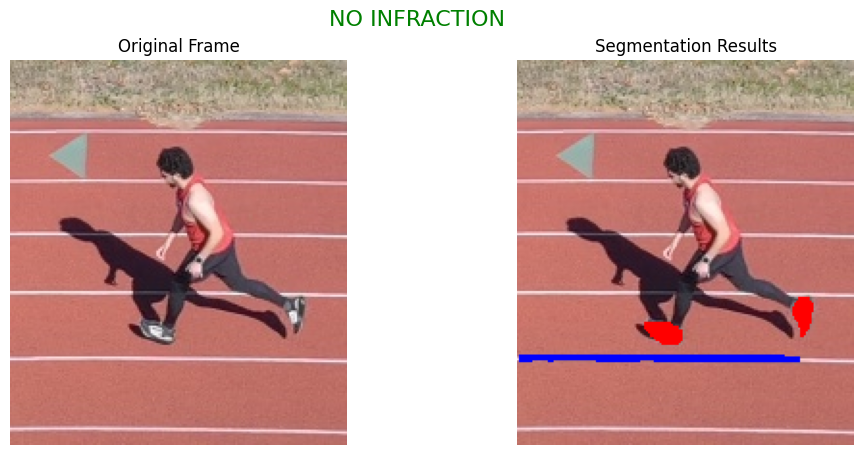

In [84]:
confidence = 10
image_path = "v1-results/1080-antonio/roi_64.jpg"
check_infraction(model, confidence, image_path, plot=True)

roi_64: No Infraction Detected


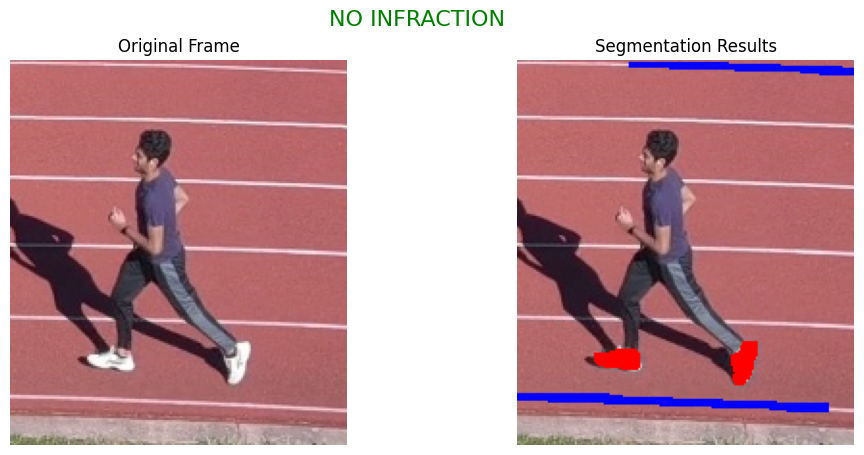

In [85]:
image_path = "v1-results/1080-athy/roi_64.jpg"
check_infraction(model, confidence, image_path, plot=True)

roi_12: Infraction Detected


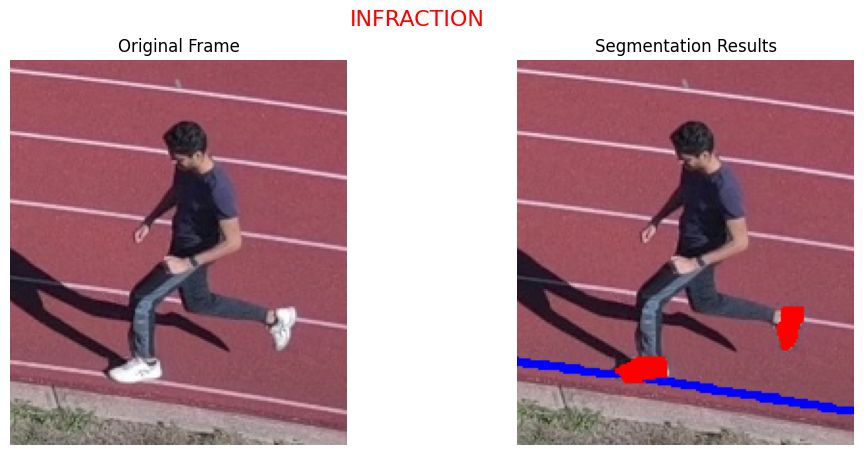

In [86]:
image_path = "v1-results/1080-athy/roi_12.jpg"
check_infraction(model, 50, image_path)